In [92]:
!pip install kaggle


In [93]:
from google.colab import files
files.upload()  # Bu komut, kaggle.json dosyasını yüklemenizi sağlar


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ogunatalay","key":"39dcae6b63bf1a8bc44823e6410b4230"}'}

In [94]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')


In [95]:
!kaggle datasets download -d "msambare/fer2013"


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [96]:
!unzip fer2013.zip


Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [97]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Veri dizinlerini tanımlıyoruz
train_dir = '/content/train'
test_dir = '/content/test'

# Görüntüleri yüklemek için fonksiyon
def load_images_from_directory(directory, img_size=(48, 48)):
    images = []
    labels = []
    label_map = {cls: idx for idx, cls in enumerate(sorted(os.listdir(directory)))}

    for label in label_map:
        class_dir = os.path.join(directory, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlama
            img = cv2.resize(img, img_size)  # 48x48'e boyutlandır
            img = np.expand_dims(img, axis=-1)  # Tek kanal (grayscale) görüntü
            images.append(img)
            labels.append(label_map[label])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Train ve test veri setlerini yükleyelim
X_train, y_train = load_images_from_directory(train_dir)
X_test, y_test = load_images_from_directory(test_dir)

# Train setini validation setine ayıralım
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Görüntüleri normalize edelim
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Etiketleri one-hot encoding (tek sıcaklık kodlama) formatına dönüştürelim
y_train = to_categorical(y_train, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# Görüntüleri RGB formatına dönüştürelim (3 kanal)
X_train_rgb = np.repeat(X_train, 3, axis=-1)  # 3 kanal ekliyoruz
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Modelin giriş şekli ile uyumlu olacak şekilde boyutları kontrol edelim
print(X_train_rgb.shape, X_val_rgb.shape, X_test_rgb.shape)


(25838, 48, 48, 3) (2871, 48, 48, 3) (7178, 48, 48, 3)


In [98]:
import tensorflow as tf
from tensorflow.keras import layers, models

# MobileNetV2 modelini yükleyelim
base_model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')

# Üzerine yeni katmanlar ekleyelim
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dense(7, activation='softmax')  # 7 sınıf
])

# Modeli derleyelim
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin özetini görelim
model.summary()


<ipython-input-98-c62e2dec7787>:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 2, 2, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,917,447 (11.13 MB)

 Trainable params: 2,883,335 (11.00 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [99]:
!pip install wandb --upgrade


In [100]:
import wandb

# Weights & Biases girişini başlatıyoruz
wandb.init(project='FER2013', entity='ogun-atalay')

# Eğitim işlemini başlatalım
history = model.fit(X_train_rgb, y_train, epochs=20, batch_size=64,
                    validation_data=(X_val_rgb, y_val))

# wandb'yi kullanarak eğitim sürecini izleyebilirsiniz
wandb.log({'train_accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']})


Epoch 1/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 101s 88ms/step - accuracy: 0.3546 - loss: 1.7040 - val_accuracy: 0.3588 - val_loss: 3.0135
Epoch 2/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 38s 27ms/step - accuracy: 0.5135 - loss: 1.2808 - val_accuracy: 0.4525 - val_loss: 1.7404
Epoch 3/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.5612 - loss: 1.1467 - val_accuracy: 0.5033 - val_loss: 1.6841
Epoch 4/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5815 - loss: 1.0969 - val_accuracy: 0.3727 - val_loss: 1.6139
Epoch 5/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.5943 - loss: 1.0666 - val_accuracy: 0.3549 - val_loss: 2.9905
Epoch 6/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.6100 - loss: 1.0432 - val_accuracy: 0.4932 - val_loss: 1.6244
Epoch 7/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6344 - loss: 0.9802 - val_accuracy: 0.5155 - val_loss: 1.5720
Epoch 8/20
404/404 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.6821 - loss: 0.8690 -

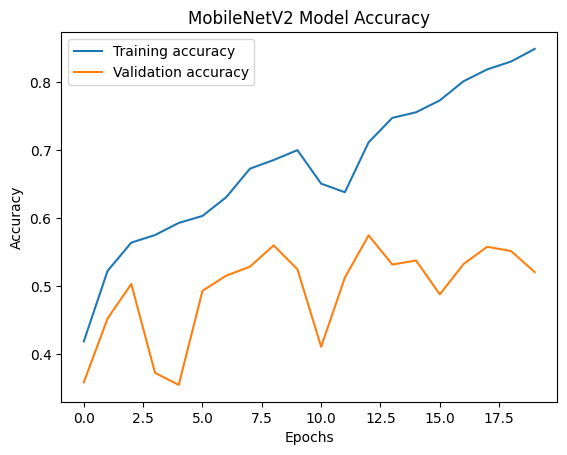

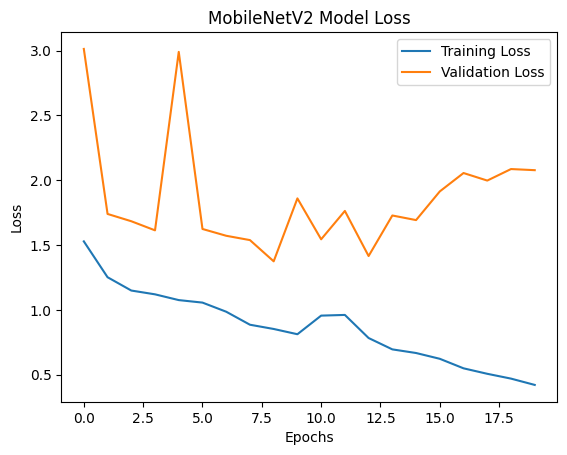

In [101]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğunu çizelim
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('MobileNetV2 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını çizelim
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MobileNetV2 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step


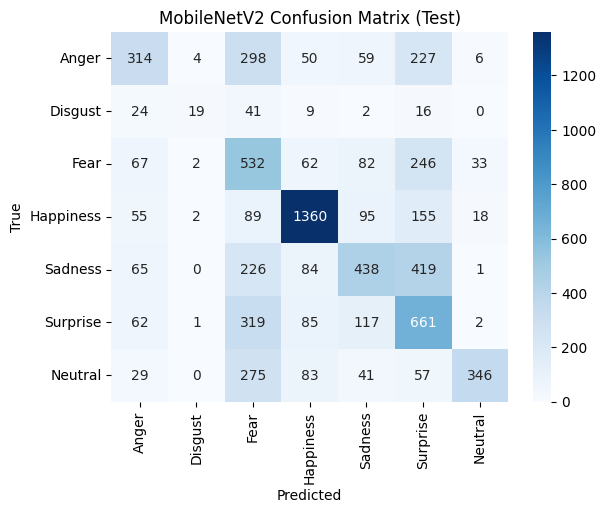

<Figure size 640x480 with 0 Axes>

In [102]:
# X_test verisini 3 kanallı (RGB) hale getirelim
X_test_rgb = np.repeat(X_test, 3, axis=-1)

# Şimdi tahminleri yapalım
y_pred = model.predict(X_test_rgb)
y_pred = np.argmax(y_pred, axis=1)  # Predicted sınıfları alıyoruz

# Gerçek etiketleri alalım (y_test zaten one-hot encoding formatında olduğu için argmax ile doğru etiketi alıyoruz)
y_true = np.argmax(y_test, axis=1)

# Karışıklık matrisini hesaplayalım
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
# Sınıf isimlerini tanımlayalım
class_names = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

# Karışıklık matrisini görselleştirelim
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MobileNetV2 Confusion Matrix (Test)')
plt.show()


# WandB'ye karışıklık matrisini görselleştirelim
wandb.log({"confusion_matrix": wandb.Image(plt)})


808/808 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step


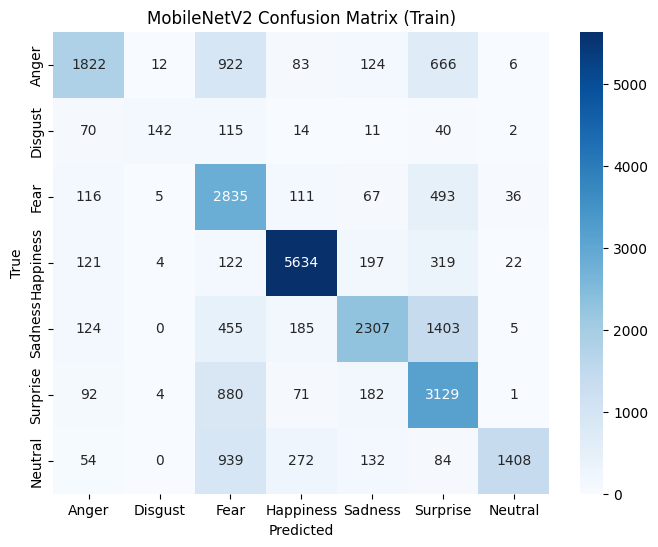

<Figure size 640x480 with 0 Axes>

In [103]:
# Train verisi için tahmin yapalım
y_pred_train = model.predict(X_train_rgb)
y_pred_train = np.argmax(y_pred_train, axis=1)  # Tahmin edilen sınıfları alıyoruz

# Gerçek etiketleri alalım
y_true_train = np.argmax(y_train, axis=1)

# Karışıklık matrisini hesaplayalım
cm_train = confusion_matrix(y_true_train, y_pred_train)

# Karışıklık matrisini görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MobileNetV2 Confusion Matrix (Train)')
plt.show()

# WandB'ye karışıklık matrisini görselleştirelim
wandb.log({"train_confusion_matrix": wandb.Image(plt)})


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step


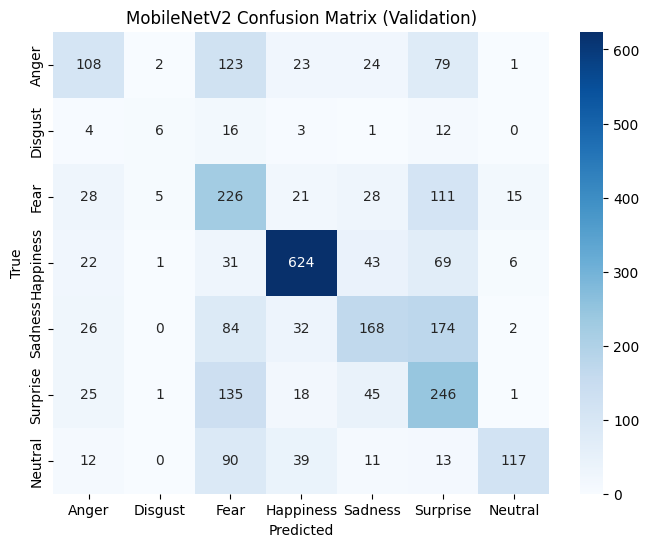

<Figure size 640x480 with 0 Axes>

In [104]:
# Validation verisi için tahmin yapalım
y_pred_val = model.predict(X_val_rgb)
y_pred_val = np.argmax(y_pred_val, axis=1)  # Tahmin edilen sınıfları alıyoruz

# Gerçek etiketleri alalım
y_true_val = np.argmax(y_val, axis=1)

# Karışıklık matrisini hesaplayalım
cm_val = confusion_matrix(y_true_val, y_pred_val)

# Karışıklık matrisini görselleştirelim
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('MobileNetV2 Confusion Matrix (Validation)')
plt.show()

# WandB'ye karışıklık matrisini görselleştirelim
wandb.log({"val_confusion_matrix": wandb.Image(plt)})


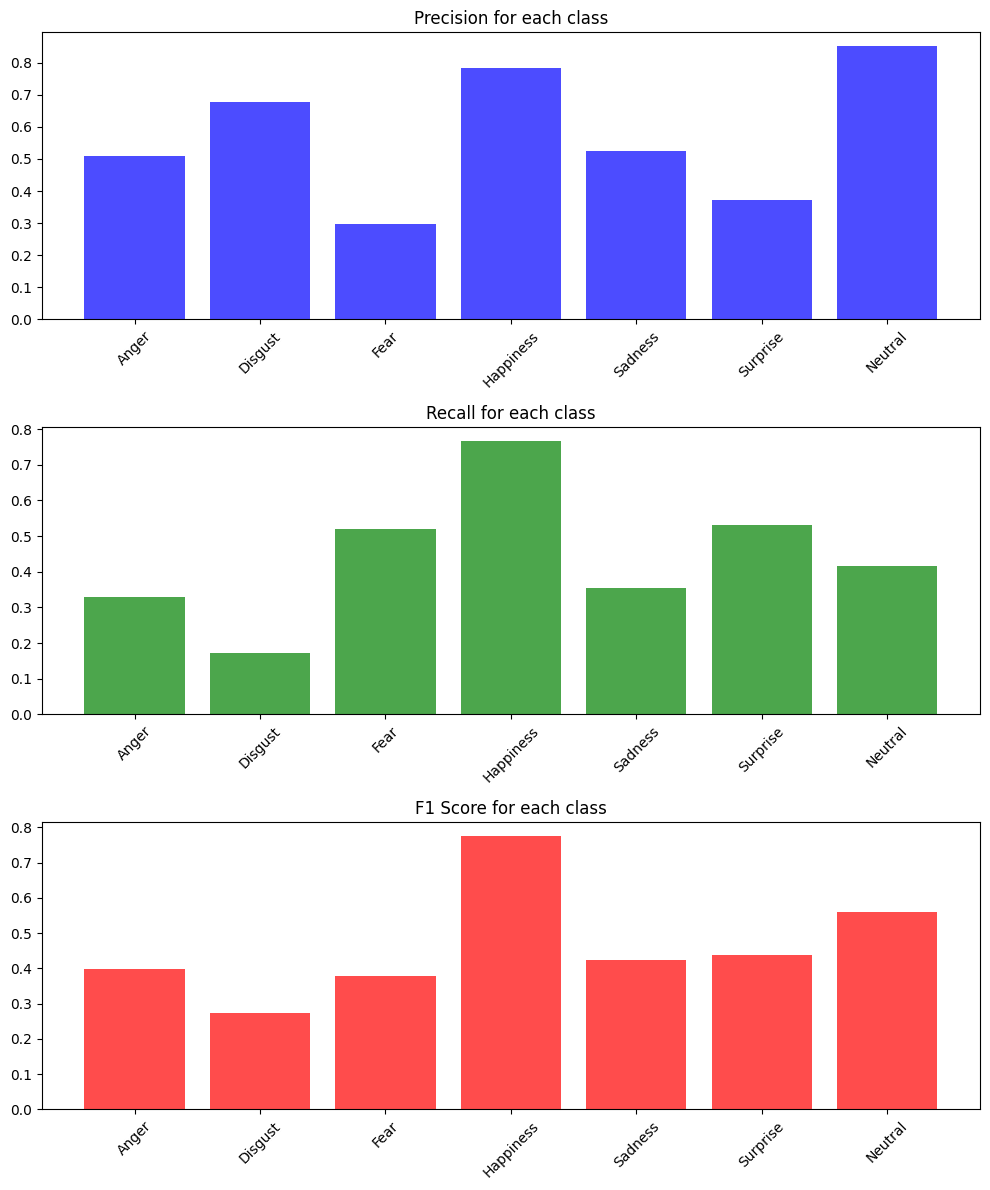

In [105]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Her sınıf için precision, recall, ve f1 skoru hesaplayalım
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Precision, Recall ve F1 skorlarını görselleştirelim
classes = class_names  # Sınıf isimlerini kullanıyoruz

# Grafiklerin alt sırasındaki başlıkları ayarlayalım
x = range(len(classes))

fig, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].bar(x, precision, color='b', alpha=0.7)
ax[0].set_title('Precision for each class')
ax[0].set_xticks(x)
ax[0].set_xticklabels(classes, rotation=45)

ax[1].bar(x, recall, color='g', alpha=0.7)
ax[1].set_title('Recall for each class')
ax[1].set_xticks(x)
ax[1].set_xticklabels(classes, rotation=45)

ax[2].bar(x, f1, color='r', alpha=0.7)
ax[2].set_title('F1 Score for each class')
ax[2].set_xticks(x)
ax[2].set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


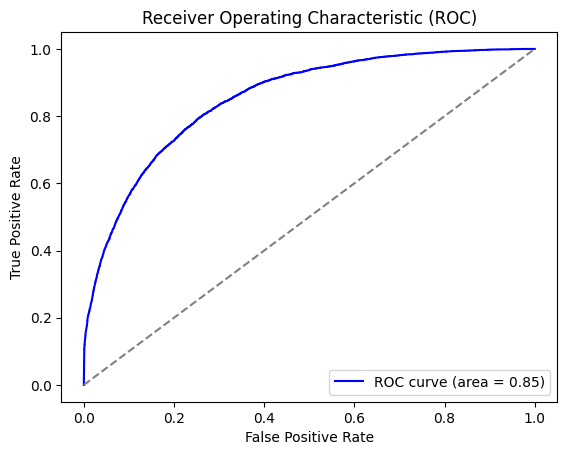

In [106]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# AUC ve ROC eğrisini çizelim
y_test_bin = label_binarize(np.argmax(y_test, axis=1), classes=range(7))  # 7 sınıf
y_pred_bin = model.predict(X_test_rgb)

fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_bin.ravel())
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizelim
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


In [ ]:
!pip install wandb


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 46, 46, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,145,927 (4.37 MB)

 Trainable params: 1,145,927 (4.37 MB)

 Non-trainable params: 0 (0.00 B)

404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.2970 - loss: 1.7372 - val_accuracy: 0.4667 - val_loss: 1.3891
Epoch 1 - Train Loss: 1.6179417371749878 - Train Accuracy: 0.36113476753234863
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4762 - loss: 1.3794 - val_accuracy: 0.5152 - val_loss: 1.2706
Epoch 2 - Train Loss: 1.34951651096344 - Train Accuracy: 0.4856413006782532
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5303 - loss: 1.2420 - val_accuracy: 0.5416 - val_loss: 1.2120
Epoch 3 - Train Loss: 1.2203422784805298 - Train Accuracy: 0.537967324256897
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5794 - loss: 1.1213 - val_accuracy: 0.5455 - val_loss: 1.1784
Epoch 4 - Train Loss: 1.1274069547653198 - Train Accuracy: 0.575934648513794
404/404 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6124 - loss: 1.0322 - val_accuracy: 0.5587 - val_loss: 1.1663
Epoch 5 - Train Loss: 1.0354903936386108 - Train Accuracy: 0.6095286011695862
404/404 ━━━━━━━━━━━━━━━━━━━

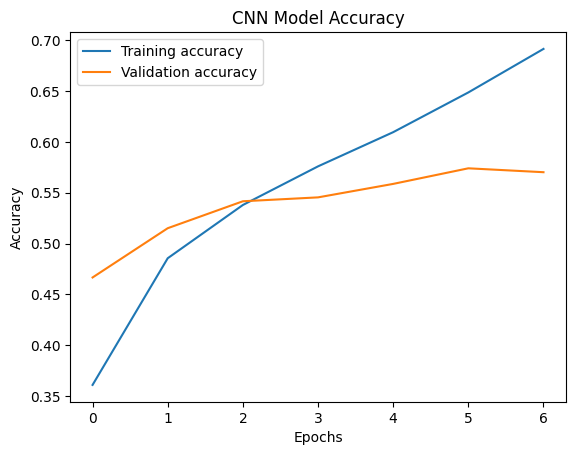

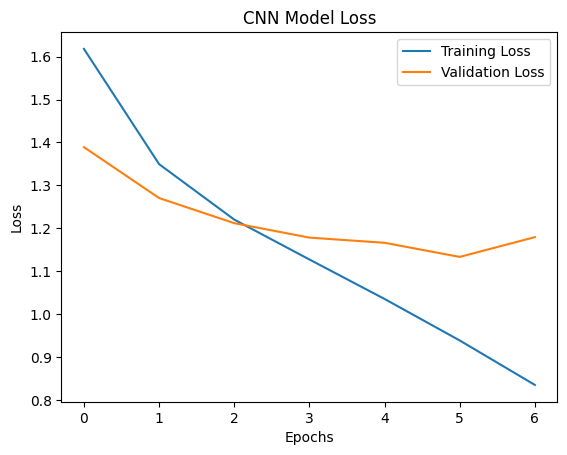

In [ ]:
import wandb

# WandB girişini başlatıyoruz
wandb.init(project='FER2013', entity='ogun-atalay')

# CNN modelini oluşturma
model = models.Sequential()

# İlk Conv2D katmanı
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# İkinci Conv2D katmanı
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Üçüncü Conv2D katmanı
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten katmanı
model.add(layers.Flatten())

# Fully Connected (Dense) katman
model.add(layers.Dense(512, activation='relu'))

# Çıktı katmanı (7 sınıf)
model.add(layers.Dense(7, activation='softmax'))  # FER2013'de 7 sınıf var

# Modeli derleyelim
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Modelin özetini görelim
model.summary()

# Eğitim metriklerini tutmak için boş listeler oluşturuyoruz
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []

# Modeli eğitirken, her epoch sonunda doğruluk ve kayıp bilgilerini WandB'ye kaydedelim
epochs = 7
batch_size = 64

for epoch in range(epochs):
    history = model.fit(X_train_rgb, y_train, epochs=1, batch_size=batch_size,
                        validation_data=(X_val_rgb, y_val))

    # Eğitim ve doğruluk kayıplarını WandB'ye loglayalım
    wandb.log({
        'epoch': epoch + 1,
        'train_accuracy': history.history['accuracy'][0],
        'val_accuracy': history.history['val_accuracy'][0],
        'train_loss': history.history['loss'][0],
        'val_loss': history.history['val_loss'][0],
    })

    # Eğitim ve doğruluk kayıplarını her epoch sonunda kaydedelim
    train_accuracy.append(history.history['accuracy'][0])
    val_accuracy.append(history.history['val_accuracy'][0])
    train_loss.append(history.history['loss'][0])
    val_loss.append(history.history['val_loss'][0])

    print(f"Epoch {epoch + 1} - Train Loss: {history.history['loss'][0]} - Train Accuracy: {history.history['accuracy'][0]}")

# Modelin doğruluğunu test verisi üzerinde ölçelim
test_loss, test_acc = model.evaluate(X_test_rgb, y_test)
print(f"Test accuracy: {test_acc}")

# Sonuçları görselleştirelim
import matplotlib.pyplot as plt

# Eğitim ve doğrulama doğruluğunu çizelim
plt.plot(train_accuracy, label='Training accuracy')
plt.plot(val_accuracy, label='Validation accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Eğitim ve doğrulama kaybını çizelim
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


808/808 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


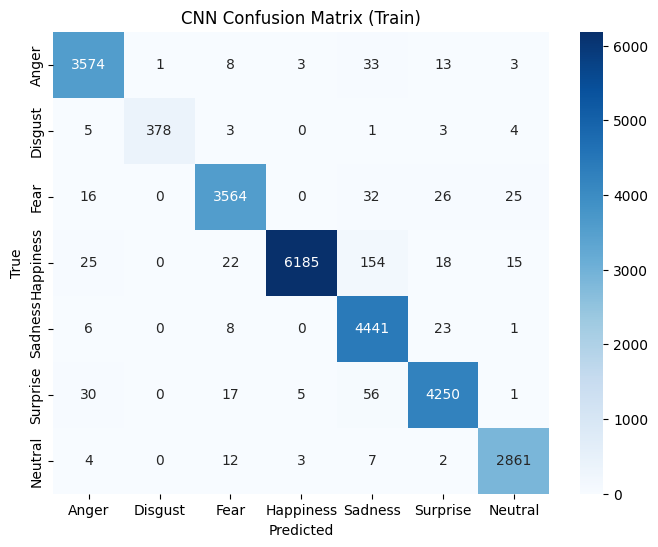

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


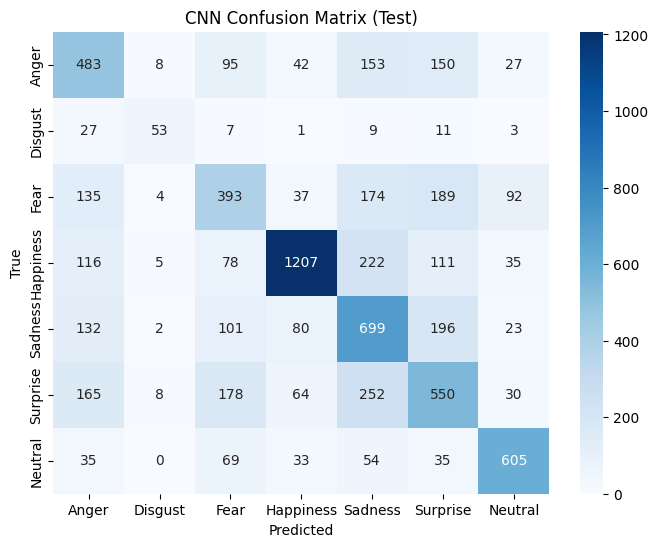

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# **Train** verisi için Confusion Matrix
y_pred_train = model.predict(X_train_rgb)
y_pred_train = np.argmax(y_pred_train, axis=1)  # Tahmin edilen sınıfları alıyoruz
y_true_train = np.argmax(y_train, axis=1)

# Train verisi için Confusion Matrix'i hesapla
cm_train = confusion_matrix(y_true_train, y_pred_train)

# Train Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix (Train)')
plt.show()

# **Test** verisi için Confusion Matrix
y_pred_test = model.predict(X_test_rgb)
y_pred_test = np.argmax(y_pred_test, axis=1)  # Tahmin edilen sınıfları alıyoruz
y_true_test = np.argmax(y_test, axis=1)

# Test verisi için Confusion Matrix'i hesapla
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Test Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix (Test)')
plt.show()


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


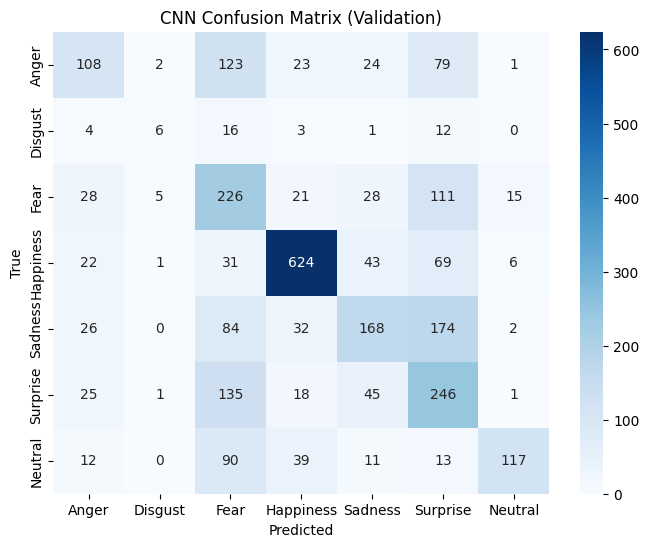

In [107]:
# **Validation** verisi için Confusion Matrix
y_pred_val = model.predict(X_val_rgb)
y_pred_val = np.argmax(y_pred_val, axis=1)  # Tahmin edilen sınıfları alıyoruz
y_true_val = np.argmax(y_val, axis=1)

# Validation verisi için Confusion Matrix'i hesapla
cm_val = confusion_matrix(y_true_val, y_pred_val)

# Validation Confusion Matrix'i görselleştir
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix (Validation)')
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


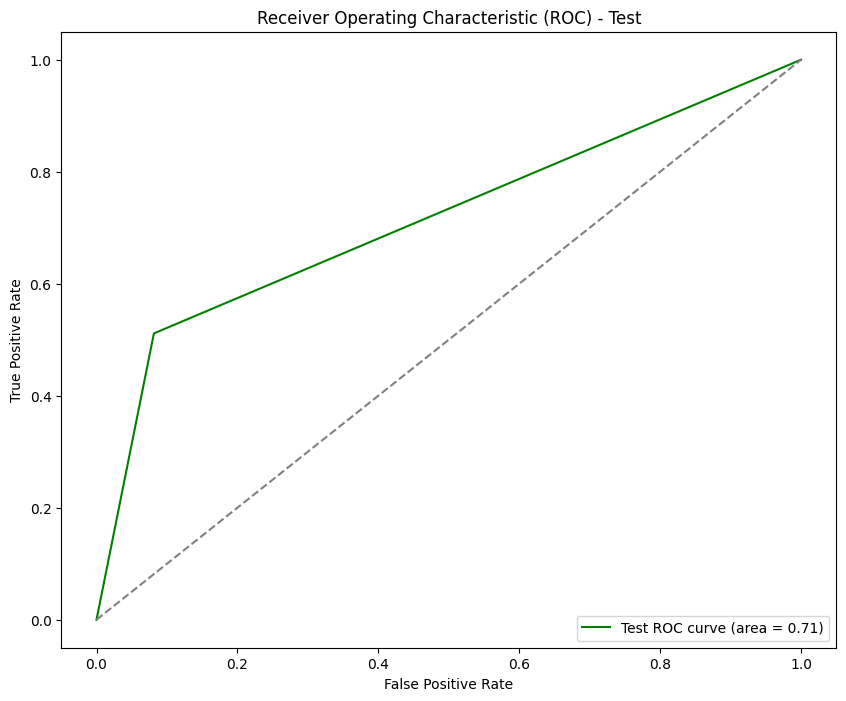

Test AUC: 0.71


In [111]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Test verisi için tahminleri alalım
y_pred_test = model.predict(X_test_rgb)

# En yüksek olasılığı seçerek sınıf tahminlerini alalım
y_pred_test_classes = np.argmax(y_pred_test, axis=1)

# Gerçek etiketleri alalım
y_true_test = np.argmax(y_test, axis=1)

# **label_binarize**: Çok sınıflı sınıflandırmada her sınıf için ikili (binary) formatta dönüştürme
y_pred_test_bin = label_binarize(y_pred_test_classes, classes=range(7))  # 7 sınıf için ikili dönüşüm
y_true_test_bin = label_binarize(y_true_test, classes=range(7))  # Gerçek etiketler de ikili formatta

# ROC eğrisini hesaplayalım
fpr_test, tpr_test, _ = roc_curve(y_true_test_bin.ravel(), y_pred_test_bin.ravel())
roc_auc_test = auc(fpr_test, tpr_test)

# ROC eğrisini görselleştirelim
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (area = {roc_auc_test:.2f})')

# Rastgele tahmin yapan modelin ROC eğrisini çiz (kesik çizgi)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Grafik ayarları
plt.title('Receiver Operating Characteristic (ROC) - Test')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# AUC değerini yazdıralım
print(f'Test AUC: {roc_auc_test:.2f}')
